In [44]:
import pandas as pd
arbres = pd.read_csv("p2-arbres-fr.csv", sep=";")
arbres.head()

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


In [45]:
arrdt = 7;
arrdt_mask = arbres["arrondissement"] == f"PARIS {arrdt}E ARRDT"
arrdt_arbres = arbres[arrdt_mask]
arrdt_arbres

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
433,100486,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,JARDIN DU CHAMP DE MARS,A0120353,Tilleul,Tilia,n. sp.,NaN,133,13,A,0.0,48.854256,2.301751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196337,2019980,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,JARDIN DU CHAMP DE MARS / C01,P00207011,If,Taxus,baccata,NaN,50,5,NaN,0.0,48.857467,2.293988
196338,2019981,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,JARDIN DU CHAMP DE MARS / C01,P00205016,If,Taxus,baccata,NaN,110,10,NaN,0.0,48.857905,2.293162
196339,2019982,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,JARDIN DU CHAMP DE MARS / C01,P00203003,Eleagnus - Chalef,Elaeagnus,angustifolia,NaN,50,5,NaN,0.0,48.858457,2.293056
196340,2019983,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,JARDIN DU CHAMP DE MARS,P0031878,If,Taxus,baccata,NaN,55,7,NaN,0.0,48.858413,2.295444


In [46]:
print(arbres["hauteur_m"].idxmax())

182852


In [47]:
especes = arbres.libelle_francais.unique()
#for i in especes:
#    print(i)
#print(arbres.arrondissement.unique())

['PARIS 7E ARRDT' 'PARIS 17E ARRDT' 'PARIS 16E ARRDT' 'PARIS 4E ARRDT'
 'PARIS 13E ARRDT' 'PARIS 12E ARRDT' 'PARIS 19E ARRDT' 'PARIS 14E ARRDT'
 'PARIS 15E ARRDT' 'PARIS 3E ARRDT' 'PARIS 20E ARRDT' 'PARIS 18E ARRDT'
 'PARIS 6E ARRDT' 'PARIS 11E ARRDT' 'PARIS 1ER ARRDT' 'PARIS 2E ARRDT'
 'PARIS 5E ARRDT' 'VAL-DE-MARNE' 'SEINE-SAINT-DENIS' 'HAUTS-DE-SEINE'
 'PARIS 9E ARRDT' 'PARIS 10E ARRDT' 'PARIS 8E ARRDT' 'BOIS DE BOULOGNE'
 'BOIS DE VINCENNES']


In [48]:
# https://geopandas.org/gallery/create_geopandas_from_pandas.html#sphx-glr-gallery-create-geopandas-from-pandas-py
# https://geopandas.org/geocoding.html
import geopandas
import os
idf = geopandas.read_file(os.path.join(os.getcwd(), "map", "geoflar-departements.shp"))

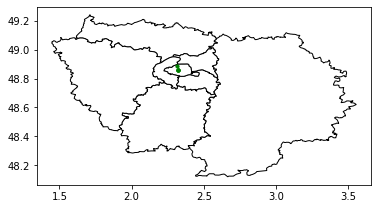

In [69]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
idf.crs = {'init':'epsg:4326'}
idf.plot(ax=ax, color="white", edgecolor="black");
test_df = arbres.head()
gdf = geopandas.GeoDataFrame(test_df, geometry=geopandas.points_from_xy(test_df.geo_point_2d_b, test_df.geo_point_2d_a))
gdf.plot(ax=ax, color='green', markersize=10)
plt.show()

<Figure size 432x288 with 0 Axes>